# Integrating multi-dataset slices of data¶

## Finding and fetching data from mouse liver (10X Genomics and Smart-Seq2)¶

In [1]:
import cellxgene_census
import scanpy as sc
import numpy as np
import scvi
from scipy.sparse import csr_matrix

Global seed set to 0
/Users/tomoya/miniconda3/envs/py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
census = cellxgene_census.open_soma(census_version="latest")

The "latest" release is currently 2023-06-05. Specify 'census_version="2023-06-05"' in future calls to open_soma() to ensure data consistency.


In [3]:
census_datasets = (
    census["census_info"]["datasets"].read(value_filter="collection_name == 'Tabula Muris Senis'").concat().to_pandas()
)

In [4]:
census_datasets.head()

,soma_joinid,collection_id,collection_name,collection_doi,dataset_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
0,484,0b9d8a04-bb9d-44da-aa27-705bb65b54eb,Tabula Muris Senis,10.1038/s41586-020-2496-1,98e5ea9f-16d6-47ec-a529-686e76515e39,All - A single-cell transcriptomic atlas chara...,98e5ea9f-16d6-47ec-a529-686e76515e39.h5ad,110824
1,485,0b9d8a04-bb9d-44da-aa27-705bb65b54eb,Tabula Muris Senis,10.1038/s41586-020-2496-1,48b37086-25f7-4ecd-be66-f5bb378e3aea,All - A single-cell transcriptomic atlas chara...,48b37086-25f7-4ecd-be66-f5bb378e3aea.h5ad,245389
2,486,0b9d8a04-bb9d-44da-aa27-705bb65b54eb,Tabula Muris Senis,10.1038/s41586-020-2496-1,3f4fe86f-aced-4d10-b174-ee35b9f46b9d,Trachea - A single-cell transcriptomic atlas c...,3f4fe86f-aced-4d10-b174-ee35b9f46b9d.h5ad,3160
3,487,0b9d8a04-bb9d-44da-aa27-705bb65b54eb,Tabula Muris Senis,10.1038/s41586-020-2496-1,c9096ac4-ea44-4cf9-82f4-af05cb83eb24,Tongue - A single-cell transcriptomic atlas ch...,c9096ac4-ea44-4cf9-82f4-af05cb83eb24.h5ad,3735
4,488,0b9d8a04-bb9d-44da-aa27-705bb65b54eb,Tabula Muris Senis,10.1038/s41586-020-2496-1,170ce19f-7a2f-4926-a1cc-adcad99e7474,Thymus - A single-cell transcriptomic atlas ch...,170ce19f-7a2f-4926-a1cc-adcad99e7474.h5ad,4047


In [5]:
tabula_liver = census_datasets["dataset_title"].str.contains("liver", case=False)

In [6]:
tabula_liver.head()

0    False
1    False
2    False
3    False
4    False
Name: dataset_title, dtype: bool

In [7]:
census_datasets.loc[tabula_liver,]

,soma_joinid,collection_id,collection_name,collection_doi,dataset_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
13,497,0b9d8a04-bb9d-44da-aa27-705bb65b54eb,Tabula Muris Senis,10.1038/s41586-020-2496-1,4546e757-34d0-4d17-be06-538318925fcd,Liver - A single-cell transcriptomic atlas cha...,4546e757-34d0-4d17-be06-538318925fcd.h5ad,2859
34,519,0b9d8a04-bb9d-44da-aa27-705bb65b54eb,Tabula Muris Senis,10.1038/s41586-020-2496-1,6202a243-b713-4e12-9ced-c387f8483dea,Liver - A single-cell transcriptomic atlas cha...,6202a243-b713-4e12-9ced-c387f8483dea.h5ad,7294


In [8]:
tabula_muris_liver_ids = ["4546e757-34d0-4d17-be06-538318925fcd", "6202a243-b713-4e12-9ced-c387f8483dea"]

In [9]:
tabula_muris_liver_ids

['4546e757-34d0-4d17-be06-538318925fcd',
 '6202a243-b713-4e12-9ced-c387f8483dea']

In [10]:
adata = cellxgene_census.get_anndata(
    census, organism="Mus musculus", obs_value_filter=f"dataset_id in {tabula_muris_liver_ids}"
)

In [11]:
census.close()
del census

In [12]:
adata.obs.assay.value_counts()

10x 3' v2     7294
Smart-seq2    2859
Name: assay, dtype: int64

## Gene-length normalization of Smart-Seq2 data.

In [13]:
smart_seq_gene_lengths = adata.var[["feature_length"]].to_numpy()

In [14]:
smart_seq_gene_lengths

array([[6094],
       [ 250],
       [1364],
       ...,
       [1849],
       [ 970],
       [ 670]])

In [15]:
smart_seq_index = np.where(adata.obs.assay == "Smart-seq2")[0]

In [16]:
smart_seq_index

array([   0,    1,    2, ..., 2856, 2857, 2858])

In [17]:
smart_seq_X = adata.X[smart_seq_index, :].copy()

In [18]:
smart_seq_X

<2859x52392 sparse matrix of type '<class 'numpy.float32'>'
	with 7108454 stored elements in Compressed Sparse Row format>

In [19]:
smart_seq_X = csr_matrix((smart_seq_X.T / smart_seq_gene_lengths).T)

In [20]:
smart_seq_X

<2859x52392 sparse matrix of type '<class 'numpy.float64'>'
	with 7108454 stored elements in Compressed Sparse Row format>

In [21]:
smart_seq_X = smart_seq_X.ceil()

In [22]:
smart_seq_X

<2859x52392 sparse matrix of type '<class 'numpy.float64'>'
	with 7108454 stored elements in Compressed Sparse Row format>

In [23]:
adata.X[smart_seq_index, :] = smart_seq_X

In [24]:
adata

AnnData object with n_obs × n_vars = 10153 × 52392
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

## Integration with scvi-tools

### Inspecting data prior to integration

In [25]:
adata.layers["counts"] = adata.X.copy()

In [26]:
adata

AnnData object with n_obs × n_vars = 10153 × 52392
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'
    layers: 'counts'

In [27]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [28]:
adata

AnnData object with n_obs × n_vars = 10153 × 52392
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'
    layers: 'counts'

In [29]:
sc.pp.log1p(adata)

In [30]:
adata

AnnData object with n_obs × n_vars = 10153 × 52392
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'
    uns: 'log1p'
    layers: 'counts'

In [31]:
sc.pp.scale(adata, max_value=10)

In [32]:
adata

AnnData object with n_obs × n_vars = 10153 × 52392
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts'

In [33]:
sc.pp.highly_variable_genes(
    adata, n_top_genes=1000, flavor="seurat_v3", layer="counts", batch_key="dataset_id", subset=True
)

In [34]:
adata

AnnData object with n_obs × n_vars = 10153 × 1000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [35]:
sc.tl.pca(adata)

In [36]:
adata

AnnData object with n_obs × n_vars = 10153 × 1000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [37]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

/Users/tomoya/miniconda3/envs/py3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tomoya/miniconda3/envs/py3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tomoya/miniconda3/envs/py3.10/lib/python3.10/site-packages/

In [38]:
adata

AnnData object with n_obs × n_vars = 10153 × 1000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [39]:
sc.tl.umap(adata)

In [40]:
adata

AnnData object with n_obs × n_vars = 10153 × 1000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

/Users/tomoya/miniconda3/envs/py3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


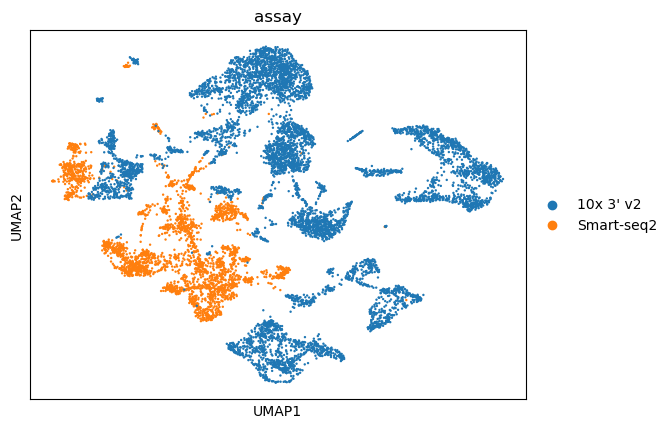

In [41]:
sc.pl.umap(adata, color="assay")

/Users/tomoya/miniconda3/envs/py3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


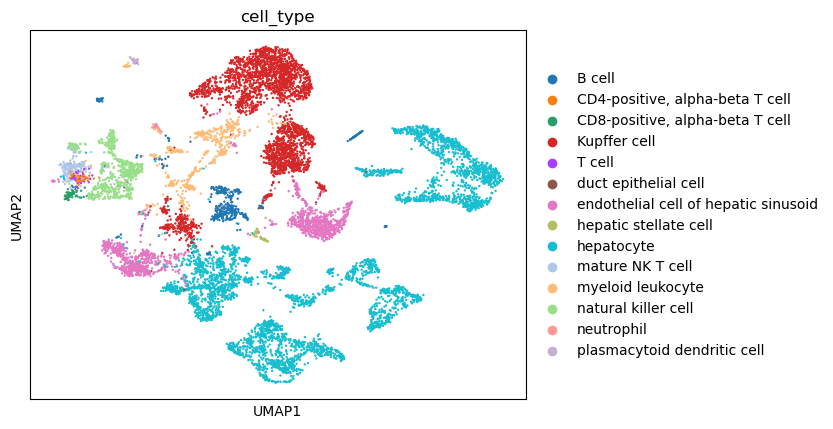

In [42]:
sc.pl.umap(adata, color="cell_type")

### Data integration with scVI¶

#### Integration with batch defined as dataset_id¶

In [43]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="dataset_id")

In [44]:
adata

AnnData object with n_obs × n_vars = 10153 × 1000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', '_scvi_batch', '_scvi_labels'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'assay_colors', 'cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [45]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb", n_hidden=50)

In [46]:
vae

SCVI Model with the following params: 
n_hidden: 50, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [47]:
vae.train(max_epochs=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|██████████| 100/100 [02:14<00:00,  1.13s/it, loss=554, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:14<00:00,  1.35s/it, loss=554, v_num=1]


In [48]:
vae

SCVI Model with the following params: 
n_hidden: 50, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [49]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [50]:
adata

AnnData object with n_obs × n_vars = 10153 × 1000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', '_scvi_batch', '_scvi_labels'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'assay_colors', 'cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [51]:
sc.pp.neighbors(adata, use_rep="X_scVI")

In [52]:
adata

AnnData object with n_obs × n_vars = 10153 × 1000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', '_scvi_batch', '_scvi_labels'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'assay_colors', 'cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [53]:
sc.tl.umap(adata)

In [54]:
adata

AnnData object with n_obs × n_vars = 10153 × 1000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', '_scvi_batch', '_scvi_labels'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'assay_colors', 'cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

/Users/tomoya/miniconda3/envs/py3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


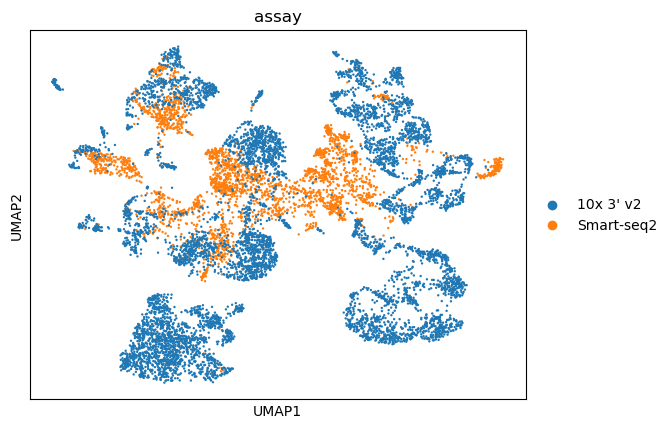

In [55]:
sc.pl.umap(adata, color="assay")

/Users/tomoya/miniconda3/envs/py3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


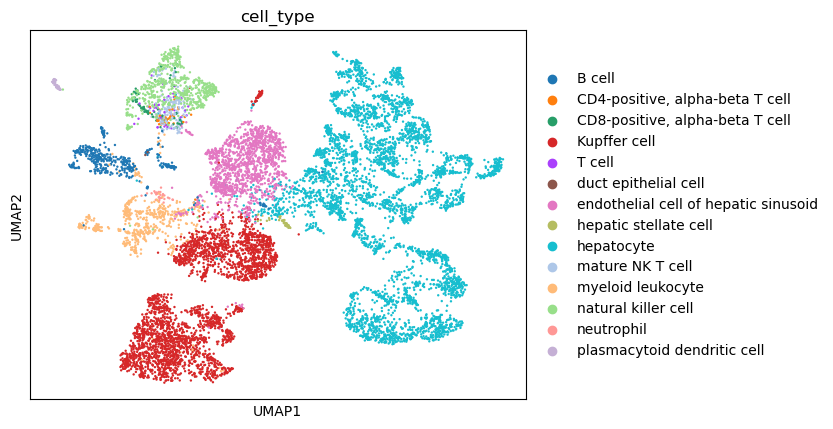

In [56]:
sc.pl.umap(adata, color="cell_type")

#### Integration with batch defined as dataset_id + donor_id

In [57]:
adata.obs["dataset_id_donor_id"] = adata.obs["dataset_id"].astype("str") + adata.obs["donor_id"].astype("str")

In [58]:
adata

AnnData object with n_obs × n_vars = 10153 × 1000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', '_scvi_batch', '_scvi_labels', 'dataset_id_donor_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'assay_colors', 'cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [59]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="dataset_id_donor_id")

In [60]:
adata

AnnData object with n_obs × n_vars = 10153 × 1000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', '_scvi_batch', '_scvi_labels', 'dataset_id_donor_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'assay_colors', 'cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [61]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb", n_hidden=50)

In [62]:
vae

SCVI Model with the following params: 
n_hidden: 50, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [63]:
vae.train(max_epochs=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|██████████| 100/100 [02:15<00:00,  1.67s/it, loss=549, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:15<00:00,  1.35s/it, loss=549, v_num=1]


In [64]:
vae

SCVI Model with the following params: 
n_hidden: 50, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [65]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [66]:
adata

AnnData object with n_obs × n_vars = 10153 × 1000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', '_scvi_batch', '_scvi_labels', 'dataset_id_donor_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'assay_colors', 'cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [67]:
sc.pp.neighbors(adata, use_rep="X_scVI")

In [68]:
adata

AnnData object with n_obs × n_vars = 10153 × 1000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', '_scvi_batch', '_scvi_labels', 'dataset_id_donor_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'assay_colors', 'cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [69]:
sc.tl.umap(adata)

In [70]:
adata

AnnData object with n_obs × n_vars = 10153 × 1000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', '_scvi_batch', '_scvi_labels', 'dataset_id_donor_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'assay_colors', 'cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

/Users/tomoya/miniconda3/envs/py3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


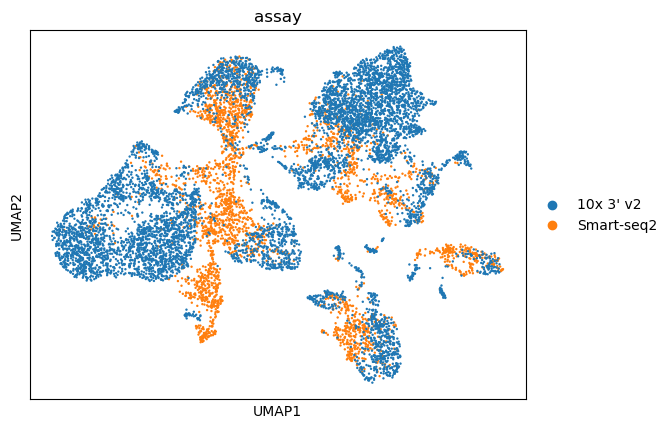

In [71]:
sc.pl.umap(adata, color="assay")

/Users/tomoya/miniconda3/envs/py3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


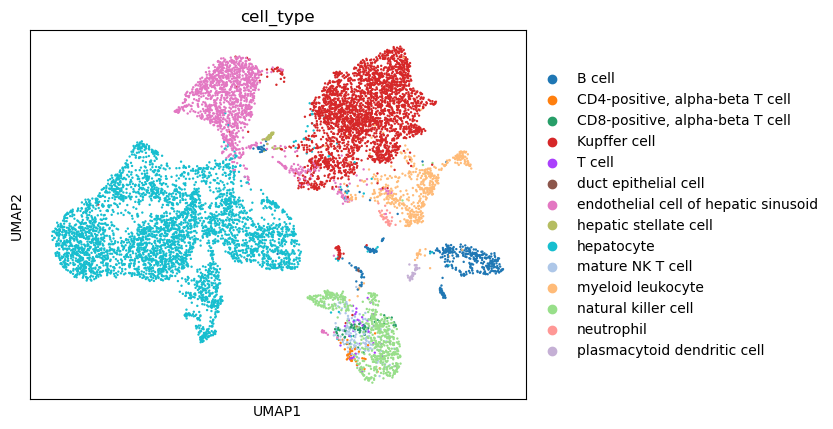

In [72]:
sc.pl.umap(adata, color="cell_type")